# Spectroscopy Analysis of Stars of Differing Spectral Types
This program demonstrates the Python pipeline for spectroscopic image reduction and wavelength calibration. It also includes a feature analysis of absorbtion lines found in different stellar spectral types (see lab report). For this project, spectroscopic data of Deneb (A2Ia), Sadr (F8Ib), and 53 Cygni (K0III) were taken at the Leitner Observatory in New Haven on November 1st by observers Elko Gerville-Reache and Isabel Shim. The main telescope used was a 16" f/8.9 RCOS ritchey-chretien with a SBIG DSS7 spectrometer and ST402ME CCD.

<img src='Deneb_Sadr_PCygni_Data\cyg_deneb_sadr.png' width="1000">

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm

In [3]:
def load_fits(img):
    '''
    loads fits data from HARPS spectrograph and outputs the header and data
    Parameters
    ----------
    img: string
        filename including path to a fits file
    Output
    ------
    data: np.ndarray[np.float64]
        NxM array of intensities
    header: 
        header of fits file
    '''
    hdu = fits.open(img)
    header = hdu[0].header
    data = (hdu[0].data).astype(np.float64)
    
    return data, header

def load_data_cube(path):
    '''
    searches for all data fits files in a directory and loads them into a numpy 3D data cube
    Parameters
    ----------
    path: string
        path to directory with fits files, will search for all files of specified extension
    Output
    ------
    data_cube: np.ndarray[np.float64]
        ixNxM array where each i index corresponds to a different fits data file
    header_list: list[astropy.io.fits.Header]
        list of each corresponding fits header file
    Example
    -------
    search for all fits files starting with 'HARPS' with .fits extention
        path = 'Spectro-Module/raw/HARPS.*.fits'
    '''
    # searches for all files within a directory
    fits_files = sorted(glob.glob(path))
    # allocate ixMxN data cube array
    i = len(fits_files)
    data, header = load_fits(fits_files[0])
    data_cube = np.zeros((i, data.shape[0], data.shape[1]))
    # save first file to data arrays
    data_cube[0,:,:] = data
    header_list = [header]
    # loop through each array in data list and store in data cube
    for i in tqdm(range(1, len(fits_files))):
        data, header = load_fits(fits_files[i])
        data_cube[i,:,:] = data
        header_list.append(header)
        
    return data_cube, header_list


deneb_cube, deneb_header = load_data_cube('Deneb_Sadr_PCygni_Data/deneb*.FIT')
sadr_cube, sadr_header = load_data_cube('Deneb_Sadr_PCygni_Data/sadir*.FIT')
pcygni_cube, pcygni_header = load_data_cube('Deneb_Sadr_PCygni_Data/53*.FIT')
dark_cube, dark_header = load_data_cube('Deneb_Sadr_PCygni_Data/dark*.FIT')
arc_cube, arc_header = load_data_cube('Deneb_Sadr_PCygni_Data/mercury*.FIT')

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 203.19it/s]


In [4]:
def calibrate_frames(data_cube, master_dark):
    '''
    reduces input files by stacking, bias subtracting, and converting flux to photo-electron units
    Parameter
    ---------
    data_cube: np.ndarray[np.float64]
        ixNxM data cube of images to be processed
    master_dark: np.ndarray[np.float64]
        master dark NxM array 
    Outputs
    -------
    calibrated_data: np.ndarray[np.float64]
        NxM stacked array of all i images   
    errors: np.ndarray[np.float64]
        NxM array corresponding to the error for each pixel 
    '''
    # dark subtract each frame
    data_cube = data_cube - master_dark
    # sum the ixMxN array along the i axis into a MxN array
    calibrated_data = np.sum(data_cube, axis = 0)

    # compute error
    # number of electrons per pixel
    readout_noise = 5
    # photon shot noise
    mask = calibrated_data > 0.0
    shot_noise = np.sqrt(calibrated_data[mask])
    # total error
    errors = np.sqrt(readout_noise**2 + shot_noise**2)
    
    return calibrated_data, errors

# compute master dark file
master_dark = np.median(dark_cube, axis = 0)
# sum frames
deneb_calibrated, deneb_errors = calibrate_frames(deneb_cube, master_dark)
sadr_calibrated, sadr_errors = calibrate_frames(sadr_cube, master_dark)
pcygni_calibrated, pcygni_errors = calibrate_frames(pcygni_cube, master_dark)
arc_calibrated, arc_errors = calibrate_frames(arc_cube, master_dark)

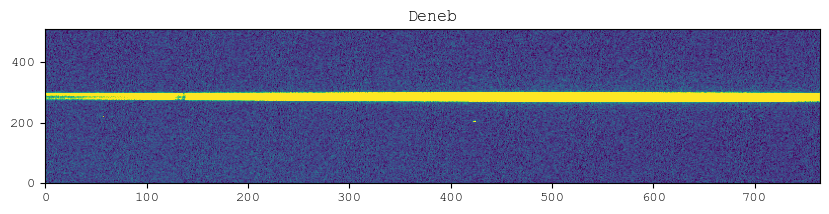

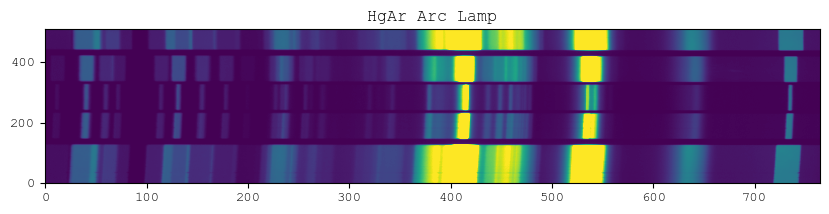

In [5]:
# display calibrated Deneb spectral order
data = deneb_calibrated
plt.figure(figsize = (10,2))
plt.rcParams['font.family'] = 'courier new'
vmin = np.percentile(data, 10)
vmax = np.percentile(data, 95)
plt.imshow(data, vmin = vmin, vmax = vmax, origin = 'lower', aspect = 'auto')
plt.title('Deneb')
plt.show()
# display calibration arc lamp spectrum
data = arc_calibrated
plt.figure(figsize = (10,2))
plt.rcParams['font.family'] = 'courier new'
vmin = np.percentile(data, 10)
vmax = np.percentile(data, 95)
plt.imshow(data, vmin = vmin, vmax = vmax, origin = 'lower', aspect = 'auto')
plt.title('HgAr Arc Lamp')
plt.show()

In [6]:
def compute_spectral_order_model(data, offset = 0):
    '''
    computes a 3rd order polynomial modeling the curvature of a spectral order
    Parameter
    ---------
    data: np.ndarray[np.float64]
        nxm array representing a spectral order from a slice of a NxM fits data array
    offset: int
        offset to shift the y-indices of the maximum values back to their original scale
        offset is equal to the lower bound of the array slice
        this is necessary as the input slice starts from 0, but the original data may have 
        a different starting index
    Output
    ------
    x_pixels: np.ndarray[np.int64]
        (m,) shaped array representing the range of x pixel values in the fits image 
    max_flux: np.ndarray[np.int64]
        (m,) shaped array representing the indeces of the maximum y values along the x axis
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    Example
    -------
        order_slice = data_cube[0][700:800, :]
        x_pixels, model = compute_spectral_order_model(order_slice, offset = 700)
        plt.plot(x_pixels, model(x_pixels))
    '''
    # for each x pixel in the input array, find the index of the max y value
    max_flux = np.argmax(data, axis = 0) + int(offset)
    # create array with range ϵ[0, max_flux.shape[0])
    x_pixels = np.arange(max_flux.shape[0])
    # compute coefficients of 3rd order polynomial
    coefficients = np.polyfit(x_pixels, max_flux, 3)
    model = np.poly1d(coefficients)
    
    return x_pixels, max_flux, model

# model spectrum order for precise extraction
x_pixels, deneb_max_flux, deneb_model = compute_spectral_order_model(deneb_calibrated[265:305,:], offset = 265)
x_pixels, sadr_max_flux, sadr_model = compute_spectral_order_model(sadr_calibrated[290:307, :], offset = 290)
x_pixels, pc_max_flux, pcygni_model = compute_spectral_order_model(pcygni_calibrated[285:300, :], offset = 285)
x_pixels, arc_max_flux, arc_model = compute_spectral_order_model(arc_calibrated[235:330,:], offset = 235)

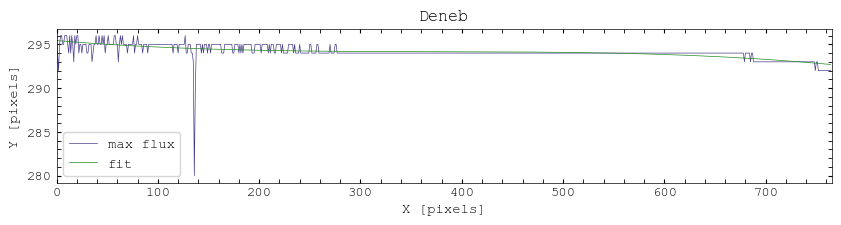

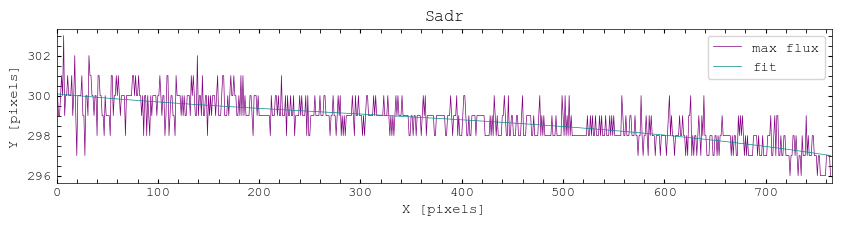

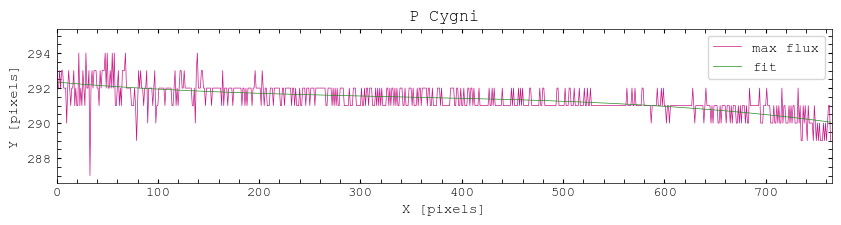

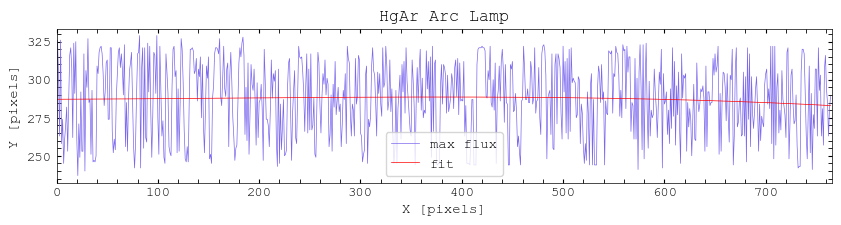

In [7]:
def plot_model(x_pixels, max_flux, model, colors, title):
    plt.figure(figsize = (10, 2))
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['axes.linewidth'] = 0.5
    plt.minorticks_on()
    plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
    plt.plot(x_pixels, max_flux, c = colors[0], lw = 0.5, label = 'max flux')
    plt.plot(x_pixels, model(x_pixels), c = colors[1], lw = 0.5, label = 'fit')
    plt.xlabel('X [pixels]')
    plt.ylabel('Y [pixels]')
    plt.xlim(0,765)
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_model(x_pixels, deneb_max_flux, deneb_model, ['darkslateblue', 'forestgreen'], 'Deneb')
plot_model(x_pixels, sadr_max_flux, sadr_model, ['purple', 'darkcyan'], 'Sadr')
plot_model(x_pixels, pc_max_flux, pcygni_model, ['mediumvioletred', 'forestgreen'], 'P Cygni')
plot_model(x_pixels, arc_max_flux, arc_model, ['mediumslateblue', 'red'], 'HgAr Arc Lamp')

In [8]:
def extract_spectral_continuum(data, x_pixels, model, window_range = 7):
    '''
    extracts the continuum flux of a spectral order by summing flux values 
    within a ±7 pixel window centered around the peak of each x-pixel
    Parameter
    ---------
    data: np.ndarray[np.float64]
        NxM stacked continuum image
    x_pixels: np.ndarray[np.int64]
        (m,) shaped array representing the range of x pixel values in the fits image 
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    window_range = int
        specifies the ± bounds for the window along the y axis to sum
    Output
    ------
    extracted_continuum: np.ndarray[np.float64]
        (M,) shaped array representing the normalized extracted spectral order at every x_pixel value
        this is the raw extracted spectrum flux before wavelength calibration        
    '''
    window_size = int(window_range*2+1)
    # 15xN data array to store the flux values in a ±7 pixel window centered at the peak y index of each x-pixel
    continuum_array = np.zeros((window_size, data.shape[1]))
    # 15x1 array of values in range ϵ[-7, 7] to broadcast a ±7 pixel window across all x pixels
    offset_range = np.arange(-window_range, int(window_range+1))[:, np.newaxis]
    # compute indeces of the maximum flux values for each x pixel, rounded to the nearest integer
    max_flux_idx = np.round(model(x_pixels)).astype(int)
    # compute a 15xN array of y-indices, where each row represents an offset from the peak flux position
    flux_window_idx = max_flux_idx + offset_range
    # extract the spectral continuum by indexing the data array using computed y-indices and x-pixels
    continuum_array = data[flux_window_idx, x_pixels]
    # sum the flux values along the y axis into a (M,) shaped array
    extracted_continuum = np.sum(continuum_array, axis = 0)
    # normalize the extracted continuum
    extracted_continuum = extracted_continuum / np.max(extracted_continuum)
    
    return extracted_continuum[::-1]

deneb_extracted = extract_spectral_continuum(deneb_calibrated, x_pixels, deneb_model, window_range = 25)
sadr_extracted = extract_spectral_continuum(sadr_calibrated, x_pixels, sadr_model, window_range = 25)
pcygni_extracted = extract_spectral_continuum(pcygni_calibrated, x_pixels, pcygni_model, window_range = 25)
arc_extracted = extract_spectral_continuum(arc_calibrated, x_pixels, arc_model, window_range = 25)

In [9]:
pixels = np.array([28.8, 228.5, 508, 585, 609, 633, 649.5, 692, 704.8, 723.5])
HgAr_lines = np.array([435.833, 546.074, 706.772, 738.393, 750.387, 763.5106, 772.376, 794.818, 801.479, 811.5311]) 

polyfit = np.polyfit(pixels, HgAr_lines, 1)
pixel_to_wavelgth = np.poly1d(polyfit)
print('linear least sqaures fit: {}'.format(pixel_to_wavelgth))

# convert xpixels to wavelengths
z = np.arange(0,765,1)
wavelength = pixel_to_wavelgth(z)

linear least sqaures fit:  
0.5395 x + 422.9


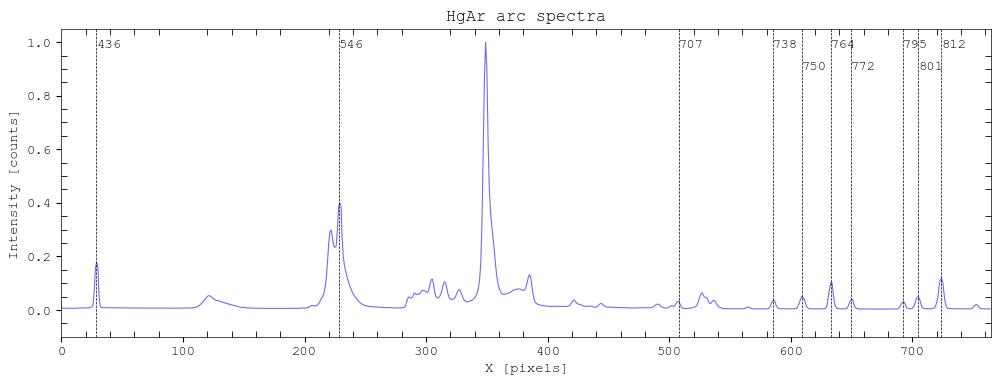

In [10]:
fig, ax = plt.subplots(figsize = (12, 4))

plt.rcParams['font.family'] = 'courier new'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = 0.6
plt.plot(arc_extracted, c = 'mediumslateblue', lw = 0.8)
displacement = [0.98,0.98,0.98,0.98,0.9,0.98,0.9,0.98,0.9,0.98]
for i, (pixel, wave) in enumerate(zip(pixels, HgAr_lines)):
    plt.vlines(pixel, -0.1, 1.05, lw = 0.5, color = 'k', ls = '--')
    plt.text(pixel, displacement[i], '{}'.format(int(np.round(wave))))
plt.xlim(0, 765)
plt.ylim(-0.1, 1.05)
plt.title('HgAr arc spectra')
plt.xlabel('X [pixels]')
plt.ylabel('Intensity [counts]')
plt.show()

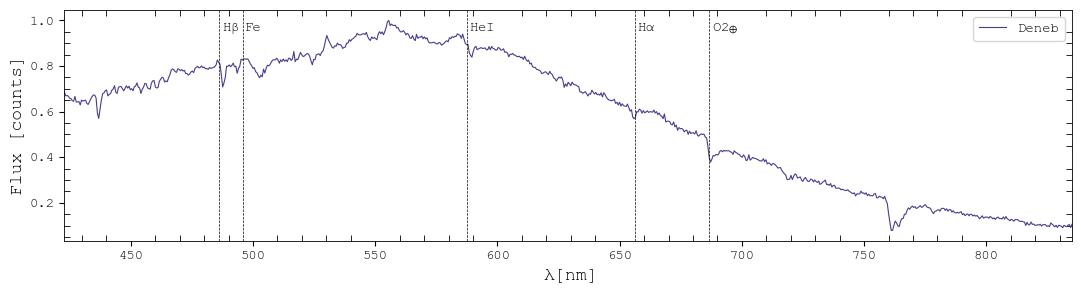

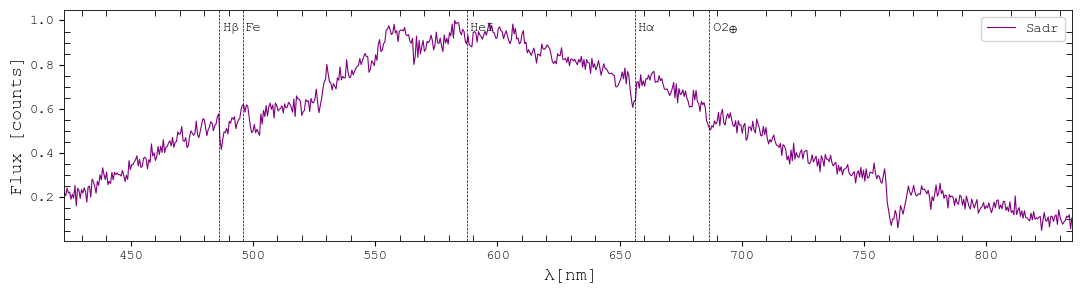

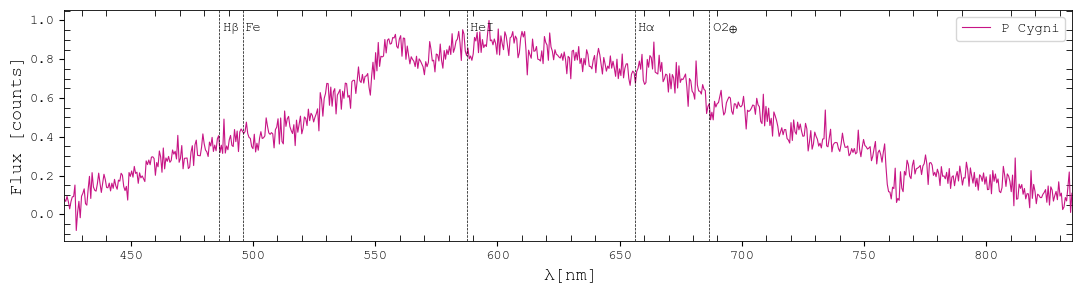

In [11]:
def plot_spectra(wavelength, flux, label, color = 'darkslateblue'):
    fig, ax = plt.subplots(figsize = (13, 3))
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['mathtext.default'] = 'regular'
    ax.minorticks_on()
    ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    plt.rcParams['axes.linewidth'] = 0.6
    
    plt.plot(wavelength, flux, lw = 0.8, c = color, label = label)
    padding = 0.05 * (np.max(flux) - np.min(flux))
    ymin = np.min(flux) - padding
    ymax = np.max(flux) + padding
    
    plt.vlines(486.13, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(487.13, ymax-2*padding, r'$H\beta$')
    plt.vlines(495.8, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(496.8, ymax-2*padding, 'Fe')
    plt.vlines(587.56, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(588.56, ymax-2*padding, r'$He I$')
    plt.vlines(656.28, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(657.28, ymax-2*padding, r'$H\alpha$')
    plt.vlines(686.7, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(687.7, ymax-2*padding, r'$O2_{\oplus}$')

    plt.xlim(wavelength[0], wavelength[-1])
    plt.ylim(ymin, ymax)
    plt.xlabel('$\lambda [nm]$', size = 13)
    plt.ylabel('Flux [counts]', size = 13)
    plt.legend()
    plt.show()
    
plot_spectra(wavelength, deneb_extracted, 'Deneb')
plot_spectra(wavelength, sadr_extracted, 'Sadr', color = 'purple')
plot_spectra(wavelength, pcygni_extracted, 'P Cygni', color = 'mediumvioletred')

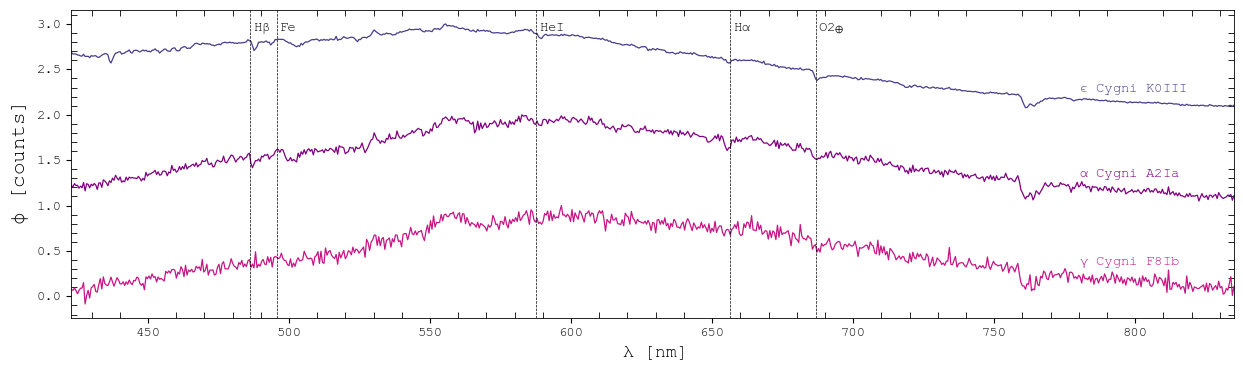

In [12]:
fig, ax = plt.subplots(figsize = (15, 4))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['mathtext.default'] = 'regular'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = 0.6

plt.plot(wavelength, deneb_extracted+2, lw = 0.9, alpha = 1, c = 'darkslateblue', label = 'Deneb A2Ia')
plt.plot(wavelength, sadr_extracted+1, lw = 0.9, alpha = 1, c = 'purple', label = 'Sadr F8Ib')
plt.plot(wavelength, pcygni_extracted, lw = 0.9, alpha = 1, c = 'mediumvioletred', label = '53 Cygni K0III')

padding = 0.05 * (np.max(deneb_extracted+2) - np.min(pcygni_extracted))
ymin = np.min(pcygni_extracted) - padding
ymax = np.max(deneb_extracted+2) + padding

plt.vlines(486.13, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(487.13, ymax-1.5*padding, r'$H\beta$')
plt.vlines(495.8, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(496.8, ymax-1.5*padding, 'Fe')
plt.vlines(587.56, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(588.56, ymax-1.5*padding, r'$He I$')
plt.vlines(656.28, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(657.28, ymax-1.5*padding, r'$H\alpha$')
plt.vlines(686.7, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(687.7, ymax-1.5*padding, r'$O2_{\oplus}$')

plt.text(780, 2.25, u'$\u03F5$ Cygni K0III', color = 'darkslateblue')
plt.text(780, 1.32, r'$\alpha$ Cygni A2Ia', color = 'purple')
plt.text(780, 0.35, r'$\gamma$ Cygni F8Ib', color = 'mediumvioletred')

plt.xlabel(r'$\lambda$ [nm]', size = 13)
plt.ylabel(r'$\phi$ [counts]', size = 15)
plt.xlim(wavelength[0], wavelength[-1])
plt.ylim(ymin, ymax)
plt.savefig('cyg_deneb_sadr.png', dpi = 400, format = 'png')
plt.show()